---
# Deep Neural Network
---

## I. Input the Libary and Perpare the Data


In [171]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [172]:
df = pd.read_csv('D:/Study/UHD/6.Spring 2022/data 4319 final project/Major Project/1. Explore Data/df_workfile.csv')
# df.info()
df.drop(columns=df.columns[0], axis=1, inplace=True)

df.head()

,diagnosis,concave points_mean,concavity_mean,concave points_worst,compactness_mean,perimeter_worst,concavity_worst,radius_worst,perimeter_mean,area_worst,area_mean,fractal_dimension_mean
0,M,0.14710,0.3001,0.2654,0.27760,184.60,0.7119,25.38,122.80,2019.0,1001.0,0.07871
1,M,0.07017,0.0869,0.1860,0.07864,158.80,0.2416,24.99,132.90,1956.0,1326.0,0.05667
2,M,0.12790,0.1974,0.2430,0.15990,152.50,0.4504,23.57,130.00,1709.0,1203.0,0.05999
3,M,0.10520,0.2414,0.2575,0.28390,98.87,0.6869,14.91,77.58,567.7,386.1,0.09744
4,M,0.10430,0.1980,0.1625,0.13280,152.20,0.4000,22.54,135.10,1575.0,1297.0,0.05883


In [173]:
benign = df[df.diagnosis == 'B']
malignant = df[df.diagnosis == 'M']

Text(0.5, 1.0, 'Linearly Data')

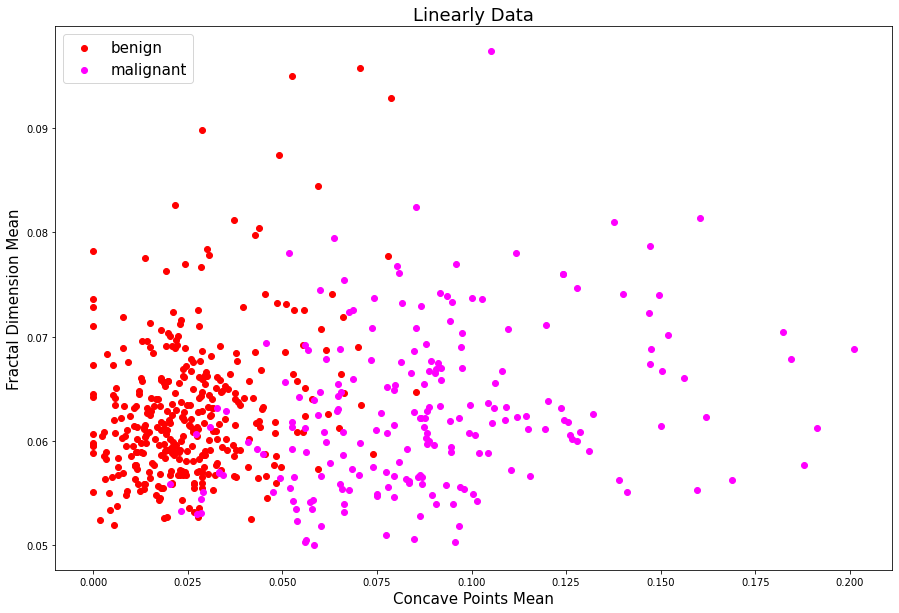

In [174]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15,10))

ax1.scatter(benign['concave points_mean'], 
            benign['fractal_dimension_mean'], 
            color = "red", 
            label = "benign")
ax1.scatter(malignant['concave points_mean'], 
            malignant['fractal_dimension_mean'], 
            color = "magenta", 
            label = "malignant")
ax1.set_xlabel("Concave Points Mean", fontsize = 15)
ax1.set_ylabel("Fractal Dimension Mean", fontsize = 15)
ax1.legend(fontsize = 15, loc = "upper left")
ax1.set_title("Linearly Data", fontsize = 18)

In [175]:
X = df.drop('diagnosis', axis = 1).values
y = df['diagnosis']
y = np.where(y == "B", 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [176]:
print(f"np.shape(X_train) ={np.shape(X_train)}")
print(f"np.shape(X_test) = {np.shape(X_test)} \n")

print(f"np.shape(X_train[0]) = {np.shape(X_train[0])}")
print(f"np.shape(X_test[0]) = {np.shape(X_test[0])} \n")

np.shape(X_train) =(398, 11)
np.shape(X_test) = (171, 11) 

np.shape(X_train[0]) = (11,)
np.shape(X_test[0]) = (11,) 



In [177]:
# Scale the data for training. 
X_train = X_train/X.max()
X_test = X_test/X.max()
# Flatten the training images into coloumn vectors. 
flat_X_train = []
# One hot encode the training labels
onehot_y_train = []

for x, y in zip(X_train, y_train):
    flat_X_train.append(x.flatten().reshape(11, 1))
    temp_vec = np.zeros((2, 1))
    temp_vec[y][0] = 1.0
    onehot_y_train.append(temp_vec)
   

# Do the same for the testing data 
flat_X_test = []
onehot_y_test = []

for x, y in zip(X_test, y_test):
    flat_X_test.append(x.flatten().reshape(11, 1))
    temp_vec = np.zeros((2, 1))
    temp_vec[y] = 1.0
    onehot_y_test.append(temp_vec)

## II. Build a Machine Learning TensorFlow and Keras
1. we will build $L$ dense with 11 input nodes, L-2 hiddent layers and 2 output node
   * For the activation function, we will use sigmoid function that we just go through in section 4: $\sigma(z) = \frac{1}{1+e^{-z}}.$
   * And the cost function, we will use Mean square error: $C(W, b) = \frac{1}{2}\sum_{k=1}^{10}(\hat{y}^{(i)}_k - y^{(i)}_k)^2.$

In [178]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))

def mse(a, y):
    return .5*sum((a[i] - y[i])**2 for i in range(2))[0]

def MSE(W, B, X, y):
    cost = 0.0
    m = 0
    for xi, yi in zip(X, y):
        a = forward_pass(W, B, xi, predict_vector = True)
        cost += mse(a, yi)
        m+=1
    return cost/m

2. Create a function to initialize the weight matrics and bias for the model

In [179]:
def initialize_weights(layers = [11, 120, 145, 120, 2]):
    # The following Python lists will contain numpy matrices
    # connected the layers in the neural network 
    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):
        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])
    
        W.append(w_temp)
        B.append(b_temp)
    return W, B

W, B = initialize_weights()


3. In each of layer in each network has two phase: Pre_activation phase and post_activation phase
   * pre_activation: $\mathbf{z}^{\ell} = W^{\ell}\mathbf{a}^{\ell-1} + \mathbf{b}^{\ell},$
     * This phase consist of weight linear combination of post_activation value of previous layer 
   * post_activation: $\mathbf{a}^{\ell} = \sigma(\mathbf{z}^{\ell}).$
     * This phase consist of passsing the pre_activation value through an activation function

In [180]:
def forward_pass(W, B, xi, predict_vector = False):
    Z = [[0.0]]
    A = [xi]
    L = len(W) - 1
    for i in range(1, L + 1):
        z = W[i] @ A[i-1] + B[i]
        Z.append(z)
        
        a = sigmoid(z)
        A.append(a)
        
    if predict_vector == False:
        return Z, A
    else:
        return A[-1]

def predict(W, B, xi):
    _, A = forward_pass(W, B, xi)
    return np.argmax(A[-1])

4. Building a dense Neural Network

In [181]:

class DenseNetwork(object):
    def __init__(self, layers =  [11, 120, 145, 120, 2]):
        self.layers = layers
        self.W, self.B = initialize_weights(layers = self.layers)

    def train(self, X_train, y_train, alpha = 0.046, epochs = 400):
        # Print the initial mean squared error
        self.errors_ = [MSE(self.W, self.B, X_train, y_train)]
        print(f"Starting Cost = {self.errors_[0]}")

        # Find your sample size
        sample_size = len(X_train)

        # Find the number of non-input layers.
        L = len(self.layers) - 1

        # For each epoch perform stochastic gradient descent. 
        for k in range(epochs):
            # Loop over each (xi, yi) training pair of data.
            for xi, yi in zip(X_train, y_train):
                # Use the forward pass function defined before
                # and find the preactivation and postactivation values.
                Z, A = forward_pass(self.W, self.B, xi)

                # Store the errors in a dictionary for clear interpretation
                # of computation of these values.
                deltas = dict()

                # Compute the output error 
                output_error = (A[L] - yi)*d_sigmoid(Z[L])
                deltas[L] = output_error

                # Loop from L-1 to 1. Recall the right entry of the range function 
                # is non-inclusive. 
                for i in range(L-1, 0, -1):
                    # Compute the node errors at each hidden layer
                    deltas[i] = (self.W[i+1].T @ deltas[i+1])*d_sigmoid(Z[i])

                # Loop over each hidden layer and the output layer to perform gradient 
                # descent. 
                for i in range(1, L+1):
                    self.W[i] -= alpha*deltas[i] @ A[i-1].T
                    self.B[i] -= alpha*deltas[i]

            # Show the user the cost over all training examples
            self.errors_.append(MSE(self.W, self.B, X_train, y_train))   
            print(f"{k + 1}-Epoch Cost = {self.errors_[-1]}")
    

    def predict(self, xi):
        depth = len(self.layers)
        _, A = forward_pass(self.W, self.B, xi)
        return np.argmax(A[-1])

5. After building a Deep neural Network, now we can test achievement

In [182]:
# Initialize a network with 11 input nodes, three hidden layers with following number of nodes 120, 145, 120 
# and a output layer with 2 nodes. 
model_DL = DenseNetwork(layers = [11, 120, 145, 120, 2])

# Check the mean squared error before training 
print(f"MSE(net.W, net.B, flat_X_train, onehot_y_train) = {MSE(model_DL.W, model_DL.B, flat_X_train, onehot_y_train)} \n")



MSE(net.W, net.B, flat_X_train, onehot_y_train) = 0.26545126939599173 



In [183]:
# Train your network with stochastic gradient descent!
model_DL.train(flat_X_train, onehot_y_train)

Starting Cost = 0.26545126939599173
1-Epoch Cost = 0.23577866222244007
2-Epoch Cost = 0.23553355397140055
3-Epoch Cost = 0.23529089670512698
4-Epoch Cost = 0.2350476676233318
5-Epoch Cost = 0.23480093195715038
6-Epoch Cost = 0.234547742888103
7-Epoch Cost = 0.2342850411378126
8-Epoch Cost = 0.23400954920212746
9-Epoch Cost = 0.23371765501677938
10-Epoch Cost = 0.2334052791361287
11-Epoch Cost = 0.23306771820518288
12-Epoch Cost = 0.2326994554882475
13-Epoch Cost = 0.23229392629646617
14-Epoch Cost = 0.23184322205258825
15-Epoch Cost = 0.23133771105705764
16-Epoch Cost = 0.230765546254865
17-Epoch Cost = 0.2301120197643178
18-Epoch Cost = 0.22935870974102654
19-Epoch Cost = 0.22848234624387928
20-Epoch Cost = 0.22745329798524513
21-Epoch Cost = 0.22623355033700843
22-Epoch Cost = 0.22477400744360654
23-Epoch Cost = 0.22301091370631668
24-Epoch Cost = 0.22086117361098048
25-Epoch Cost = 0.2182164171130978
26-Epoch Cost = 0.21493597767857656
27-Epoch Cost = 0.21083991611712297
28-Epoch Co

In [184]:
result_table = pd.DataFrame()
actual_digit = []
predict_digit = []
for index in range(0, len(flat_X_test)):

    actual_digit.append(np.argmax(onehot_y_test[index]))
    predict_digit.append(model_DL.predict(flat_X_test[index]))
    
result_table["test_y"], result_table["predict_y"] = [actual_digit, predict_digit]
result_table

,test_y,predict_y
0,0,0
1,1,1
2,0,0
3,1,1
4,0,0
...,...,...
166,0,0
167,1,0
168,0,0
169,0,0


6. Classification Error

Classification Accuracy: 91.23%


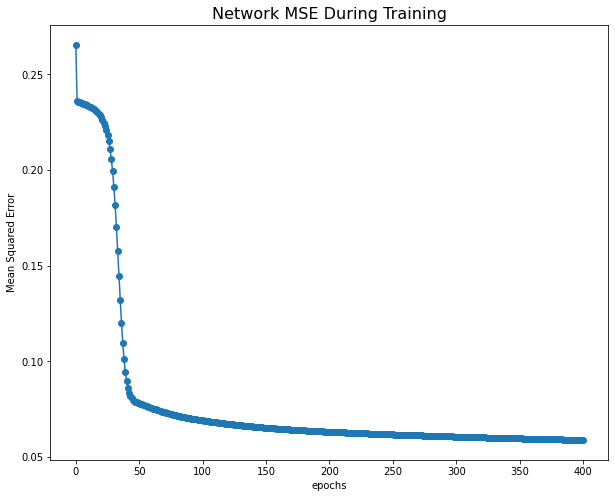

In [185]:
# Compute the classification accuracy of our trained model on the test data (I bet we did well!)
clf_acc = sum([int(model_DL.predict(x) == y) for x, y in zip(flat_X_test, y_test)])/len(onehot_y_test)
clf_acc = "{:.2%}".format(clf_acc)
print(f"Classification Accuracy: {clf_acc}")

# Visualize the mean squared error over the training process 
plt.figure(figsize = (10, 8))
epochs = range(len(model_DL.errors_))
plt.plot(epochs, model_DL.errors_, marker = "o")
plt.xticks(np.arange(0, len(epochs), 50))
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.title("Network MSE During Training", fontsize = 16)
plt.show()
